In [1]:
import pandas as pd
import numpy as np 
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas_datareader as pdr
from forex_python.converter import CurrencyRates
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [6]:
# Initial Data imports

silver_import = pd.read_csv('/Users/aidanolson/Desktop/gold and silver project/silver prices.csv')
gold_import = pd.read_csv('/Users/aidanolson/Desktop/gold and silver project/gold prices.csv')

# Change domain to before the pandemic which affected the economy on an unpredictable and massive scale.

pandemic_start_date = int(len(silver_import) * 0.34) # Brute forced this number looking for early march 2020 (beginning of pandemic)

silver = silver_import[pandemic_start_date:]
gold = gold_import[pandemic_start_date:]

start = "2013-08-19"
end = pd.to_datetime(silver['Date'])[pandemic_start_date] # Standardize the date range for all data sets

treasury = yf.download("^TNX", start, end)
treasury = treasury.reset_index()

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-08-19,2.846,2.899,2.836,2.884,2.884,0
1,2013-08-20,2.811,2.838,2.811,2.814,2.814,0
2,2013-08-21,2.818,2.884,2.811,2.855,2.855,0
3,2013-08-22,2.916,2.920,2.873,2.901,2.901,0
4,2013-08-23,2.910,2.916,2.804,2.818,2.818,0
...,...,...,...,...,...,...,...
1646,2020-03-06,0.714,0.789,0.660,0.706,0.706,0
1647,2020-03-09,0.484,0.601,0.398,0.499,0.499,0
1648,2020-03-10,0.654,0.756,0.565,0.748,0.748,0
1649,2020-03-11,0.707,0.862,0.675,0.820,0.820,0


In [7]:
silver.info() #Need to fix NA values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1676 entries, 863 to 2538
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1676 non-null   object 
 1   Close/Last  1676 non-null   float64
 2   Volume      1615 non-null   float64
 3   Open        1676 non-null   float64
 4   High        1676 non-null   float64
 5   Low         1676 non-null   float64
dtypes: float64(5), object(1)
memory usage: 78.7+ KB


In [8]:
silver_null = silver.isnull().sum()
print(silver_null)

Date           0
Close/Last     0
Volume        61
Open           0
High           0
Low            0
dtype: int64


There are 61 null volumes, so we can replace these with the average of the non null volumes to ensure that these values don't mess with the aggregations of our data.

In [9]:
silver['Date'] = pd.to_datetime(silver['Date'])
silver['Year'] = silver['Date'].dt.year
gold['Date'] = pd.to_datetime(gold['Date'])
gold['Year'] = gold['Date'].dt.year
treasury['Date'] = pd.to_datetime(treasury['Date'])
treasury['Year'] = treasury['Date'].dt.year

/var/folders/qp/47sbgf9n72n0thwvv8hlq7jw0000gn/T/ipykernel_49538/1306939048.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  silver['Date'] = pd.to_datetime(silver['Date'])
/var/folders/qp/47sbgf9n72n0thwvv8hlq7jw0000gn/T/ipykernel_49538/1306939048.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  silver['Year'] = silver['Date'].dt.year
/var/folders/qp/47sbgf9n72n0thwvv8hlq7jw0000gn/T/ipykernel_49538/1306939048.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

In [10]:
silver_volume_mean = silver.groupby('Year')['Volume'].mean()
silver_volume_mean

Year
2013    34946.614458
2014    40468.616935
2015    39194.807692
2016    54560.357143
2017    70795.003984
2018    70378.805556
2019    60724.437247
2020    62214.312500
Name: Volume, dtype: float64

In [11]:
for year, mean_value in silver_volume_mean.items():
    silver.loc[(silver['Year'] == year) & (silver['Volume'].isna()), 'Volume'] = mean_value

silver.isna().sum()

Date          0
Close/Last    0
Volume        0
Open          0
High          0
Low           0
Year          0
dtype: int64

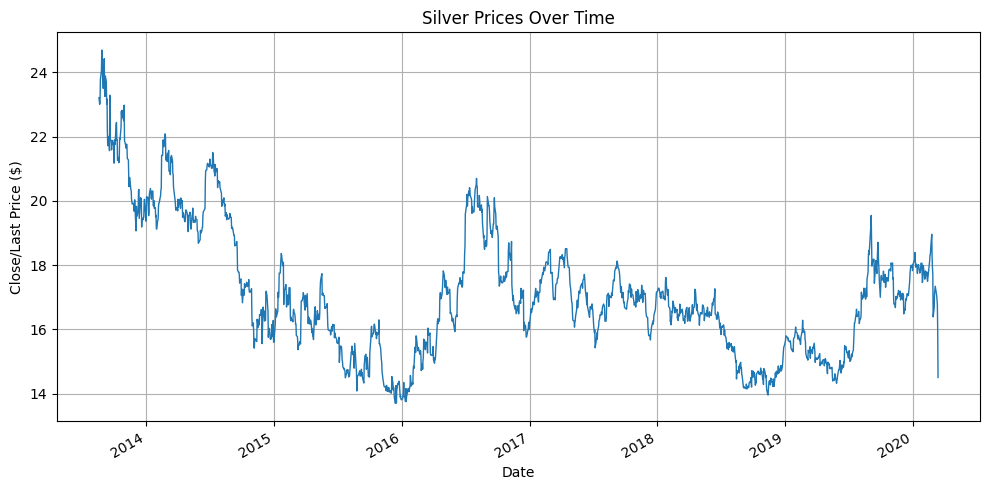

In [12]:
#Start plotting
plt.figure(figsize=(10, 5))

#Create line plot
plt.plot(silver['Date'], silver['Close/Last'], linewidth=1)  

#Adding the title and labels
plt.title('Silver Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close/Last Price ($)')

plt.gcf().autofmt_xdate()
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
silver['Daily Return'] = silver['Close/Last'].pct_change().dropna()
gold['Daily Return'] = gold['Close/Last'].pct_change().dropna()
treasury['Daily Return'] = treasury['Close'].pct_change().dropna()
silver.head()

/var/folders/qp/47sbgf9n72n0thwvv8hlq7jw0000gn/T/ipykernel_49538/975842381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  silver['Daily Return'] = silver['Close/Last'].pct_change().dropna()
/var/folders/qp/47sbgf9n72n0thwvv8hlq7jw0000gn/T/ipykernel_49538/975842381.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gold['Daily Return'] = gold['Close/Last'].pct_change().dropna()


,Date,Close/Last,Volume,Open,High,Low,Year,Daily Return
863,2020-03-13,14.500,153960.0,15.825,15.890,14.425,2020,NaN
864,2020-03-12,16.005,136523.0,16.720,16.910,15.505,2020,0.103793
865,2020-03-11,16.776,54867.0,16.875,17.110,16.660,2020,0.048172
866,2020-03-10,16.906,97.0,16.850,17.145,16.765,2020,0.007749
867,2020-03-09,17.054,124720.0,17.490,17.615,16.550,2020,0.008754


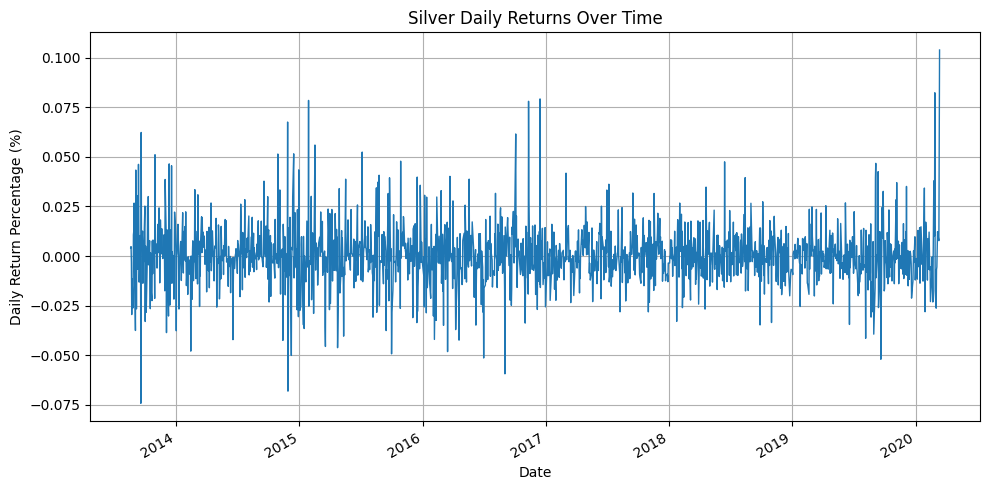

In [14]:
#Start plotting
plt.figure(figsize=(10, 5))

#Create line plot
plt.plot(silver['Date'], silver['Daily Return'], linewidth=1)  

#Adding the title and labels
plt.title('Silver Daily Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Return Percentage (%)')

plt.gcf().autofmt_xdate()
plt.grid(True)
plt.tight_layout()

plt.show()

In [15]:
def calculate_annualized_volatility(daily_returns):
    # calculate the daily standard deviation of returns
    daily_std = np.std(daily_returns)

    # convert daily standard deviation to annualized volatility
    # 252 trading days in a year
    annualized_volatility = daily_std * np.sqrt(252)

    return annualized_volatility

ann_vol = calculate_annualized_volatility(silver['Daily Return']) 
ann_vol

0.23932612769489167

In [16]:
# S&P500
market = yf.download('^GSPC', start, end)


[*********************100%%**********************]  1 of 1 completed


In [17]:
market.reset_index()
market['Daily Return'] = market['Close'].pct_change().dropna()

In [18]:
# Compare return against S&P500 and bond yield data
bond_data = yf.download('IEF', start, end)

bond_data.reset_index()
bond_data['Daily Return'] = bond_data['Close'].pct_change().dropna()

[*********************100%%**********************]  1 of 1 completed


Mean Annual Returns:
 Silver      0.089477
Gold       -0.008004
Treasury   -0.106954
S&P 500     0.072828
Bonds       0.028046
dtype: float64
Annual Volatility:
 Silver      0.235576
Gold        0.140008
Treasury    0.404735
S&P 500     0.145501
Bonds       0.053916
dtype: float64
Sharpe Ratios:
 Silver      0.379822
Gold       -0.057168
Treasury   -0.264257
S&P 500     0.500530
Bonds       0.520181
dtype: float64


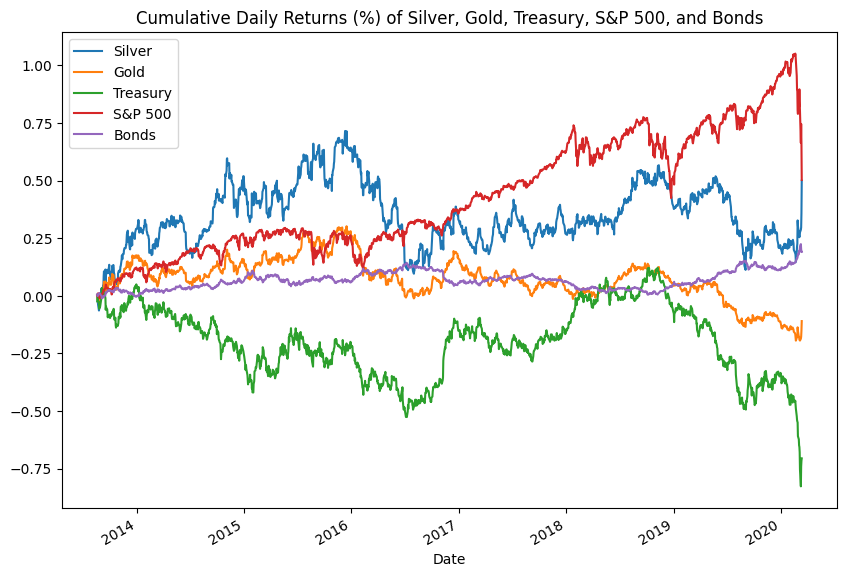

In [19]:
# Combine our Daily Returns into a single DataFrame
treasury_returns = treasury.set_index('Date')
gold_combined_returns = gold.set_index('Date')
silver_combined_returns = silver.set_index('Date') # Important to standardize everything coming up...

combined_returns = pd.DataFrame({
    'Silver': silver_combined_returns['Daily Return'].dropna(),
    'Gold': gold_combined_returns['Daily Return'].dropna(),
    'Treasury': treasury_returns['Daily Return'],
    'S&P 500': market['Daily Return'].dropna(),
    'Bonds': bond_data['Daily Return'].dropna()
}).dropna()

# Calculate mean and volatility
mean_returns = combined_returns.mean() * 252  # Annualize the mean returns
volatility = combined_returns.std() * np.sqrt(252)  # Annualize the volatility

# Risk-adjusted return (Sharpe Ratio) - assuming risk-free rate is 0 for simplicity
sharpe_ratios = mean_returns / volatility

# Plot cumulative returns
cumulative_returns = (1 + combined_returns).cumprod() - 1
cumulative_returns.plot(figsize=(10, 7))

# Display results
print("Mean Annual Returns:\n", mean_returns)
print("Annual Volatility:\n", volatility)
print("Sharpe Ratios:\n", sharpe_ratios)
plt.title('Cumulative Daily Returns (%) of Silver, Gold, Treasury, S&P 500, and Bonds')
plt.show()

In [20]:
# Economic Influence Analysis
# We compare the trends of gold to inflation, interest rate, GDP, and exchange rate data

inflation_data = pdr.get_data_fred('CPIAUCSL', start, end)
interest_rate_data = pdr.get_data_fred('DGS10', start, end)
gdp_data = pdr.get_data_fred('GDP', start, end)

# Exchange rate Data
c = CurrencyRates()
dates = pd.date_range(start, end, freq='M')
usd_to_eur_rates = [c.get_rate('USD', 'EUR', date) for date in dates]
exchange_rate_data = pd.DataFrame({'Date': dates, 'USD_to_EUR': usd_to_eur_rates})

exchange_rate_data_date = exchange_rate_data.set_index('Date')
exchange_rate_data_date.rename_axis('DATE', inplace=True)

In [21]:
# Correlation Matrix Calculation

exchange_rate_data['Date'] = pd.to_datetime(exchange_rate_data['Date'])
exchange_rate_data.set_index('Date', inplace=True)

inflation_data = inflation_data.reset_index()
inflation_data['Date'] = pd.to_datetime(inflation_data['DATE'])
inflation_data.set_index('Date', inplace=True)

gdp_data = gdp_data.reset_index()
gdp_data['Date'] = pd.to_datetime(gdp_data['DATE'])
gdp_data.set_index('Date', inplace=True)

# Resample to daily frequency and interpolate
daily_exchange_data = exchange_rate_data.resample('D').interpolate('linear')
daily_inflation_data = inflation_data.resample('D').interpolate('linear')
daily_gdp_data = gdp_data.resample('D').interpolate('linear')

combined_returns_2 = pd.DataFrame({
    'Silver Returns': silver_combined_returns['Daily Return'],
    'Gold Returns': gold_combined_returns['Daily Return'],
    'Inflation Rate': daily_inflation_data['CPIAUCSL'],  
    'Interest Rate': interest_rate_data['DGS10'],  
    'Exchange Rate': daily_exchange_data['USD_to_EUR'],
    'GDP': daily_gdp_data['GDP']
})

# Drop NaN values and calculate the correlation matrix
combined_data = combined_returns_2.dropna()

correlation_matrix = combined_data.corr()
print(correlation_matrix)

                Silver Returns  Gold Returns  Inflation Rate  Interest Rate  \
Silver Returns        1.000000      0.794225       -0.016136       0.039155   
Gold Returns          0.794225      1.000000       -0.021779       0.017173   
Inflation Rate       -0.016136     -0.021779        1.000000       0.123969   
Interest Rate         0.039155      0.017173        0.123969       1.000000   
Exchange Rate        -0.022761     -0.016701        0.327355      -0.487271   
GDP                  -0.020322     -0.024385        0.985895       0.038408   

                Exchange Rate       GDP  
Silver Returns      -0.022761 -0.020322  
Gold Returns        -0.016701 -0.024385  
Inflation Rate       0.327355  0.985895  
Interest Rate       -0.487271  0.038408  
Exchange Rate        1.000000  0.446912  
GDP                  0.446912  1.000000  


In [22]:
# Creating a Regression Model

# Standardize indexing to date
treasury_date = treasury.set_index('Date') 
silver_date = silver.set_index('Date')
gold_date = gold.set_index('Date')


combined_close = pd.DataFrame({
    'Silver': silver_date['Close/Last'],
    'Gold': gold_date['Close/Last'],
    'Treasury': treasury_date['Close'],  
    'S&P 500': market['Close'],  
    'Bonds': bond_data['Close']
})

# Fill in missing values via Interpolation
combined_close_interp = combined_close.interpolate('linear')

X_silver = combined_close_interp[['Treasury', 'S&P 500', 'Bonds', 'Gold']]  # Independent variables
y_silver = combined_close_interp['Silver']  # Dependent variable

X_gold = combined_close_interp[['Treasury', 'S&P 500', 'Bonds', 'Silver']]
y_gold = combined_close_interp['Gold']

# Create an OLS model and fit it
silver_model = sm.OLS(y_silver, X_silver).fit()

print(silver_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                 Silver   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          1.694e+05
Date:                Fri, 01 Dec 2023   Prob (F-statistic):                        0.00
Time:                        16:04:27   Log-Likelihood:                         -2116.9
No. Observations:                1676   AIC:                                      4242.
Df Residuals:                    1672   BIC:                                      4264.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [23]:
combined_close_interp.head(10)

,Silver,Gold,Treasury,S&P 500,Bonds
Date,,,,,
2013-08-19,23.215,1365.7,2.884,1646.060059,99.709999
2013-08-20,23.118,1372.6,2.814,1652.349976,100.250000
2013-08-21,23.009,1370.1,2.855,1642.800049,99.620003
2013-08-22,23.080,1370.8,2.901,1656.959961,99.580002
2013-08-23,23.781,1395.8,2.818,1663.500000,100.139999
2013-08-26,24.055,1393.1,2.805,1656.780029,100.339996
2013-08-27,24.700,1420.2,2.721,1630.479980,100.910004
2013-08-28,24.439,1418.8,2.782,1634.959961,100.500000
2013-08-29,24.140,1412.9,2.751,1638.170044,100.599998


In [24]:
split_point = int(len(combined_close_interp) * 0.7)

# Split the data into training and testing sets
X_silver_train = X_silver[:split_point]
y_silver_train = y_silver[:split_point]
X_silver_test = X_silver[split_point:]
y_silver_test = y_silver[split_point:]

# Add a constant to the training set for the intercept
X_silver_train = sm.add_constant(X_silver_train)

# Fit the OLS model on the training data
silver_model = sm.OLS(y_silver_train, X_silver_train).fit()

# Add a constant to the testing set for the intercept
X_silver_test = sm.add_constant(X_silver_test)

# Make predictions on the testing set
y_silver_pred = silver_model.predict(X_silver_test)

# Calculate the root mean squared error (RMSE) for the predictions
silver_test_rmse = rmse(y_silver_test, y_silver_pred)
print(f'Test RMSE: {silver_test_rmse}')


Test RMSE: 1.779431928758317


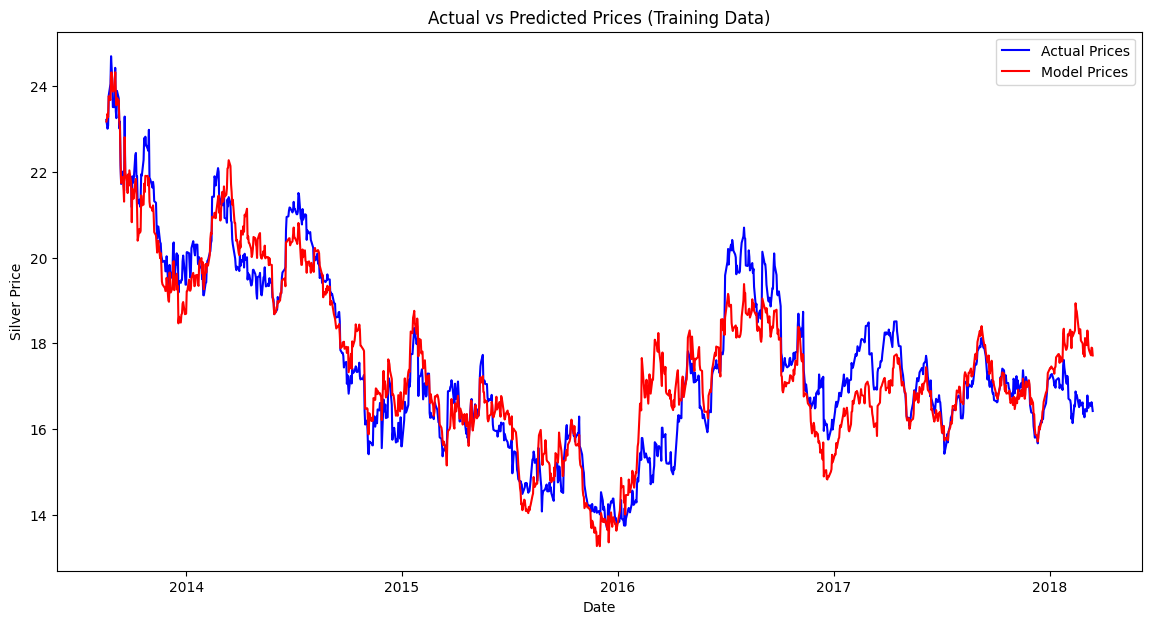

Training RMSE: 0.7384247123224521


In [25]:
y_silver_train_pred = silver_model.predict(sm.add_constant(X_silver_train))

# Calculate the RMSE for the training predictions
silver_train_rmse = rmse(y_silver_train, y_silver_train_pred)

# Plotting the actual vs model prices for the training set
plt.figure(figsize=(14, 7))
plt.plot(y_silver_train.index, y_silver_train, label='Actual Prices', color='blue')
plt.plot(y_silver_train.index, y_silver_train_pred, label='Model Prices', color='red')

# Adding titles and labels
plt.title(f'Actual vs Predicted Prices (Training Data)')
plt.xlabel('Date')
plt.ylabel('Silver Price')
plt.legend()
plt.show()
print(f'Training RMSE: {silver_train_rmse}')

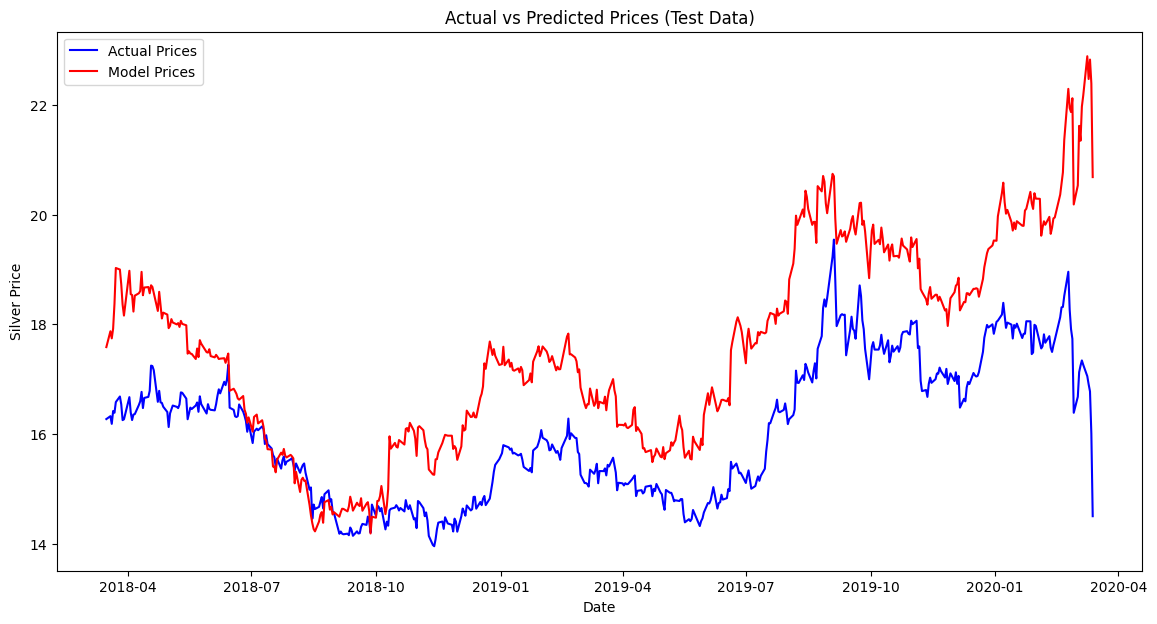

Test RMSE: 1.779431928758317


In [26]:
# Plotting the actual vs predicted prices

plt.figure(figsize=(14, 7))
plt.plot(y_silver_test.index, y_silver_test, label='Actual Prices', color='blue')
plt.plot(y_silver_test.index, y_silver_pred, label='Model Prices', color='red')

# Adding titles and labels
plt.title(f'Actual vs Predicted Prices (Test Data)')
plt.xlabel('Date')
plt.ylabel('Silver Price')
plt.legend()
plt.show()
print(f'Test RMSE: {silver_test_rmse}')

In [27]:
# Split the data into training and testing sets
X_gold_train = X_gold[:split_point]
y_gold_train = y_gold[:split_point]
X_gold_test = X_gold[split_point:]
y_gold_test = y_gold[split_point:]

# Add a constant to the training set for the intercept
X_gold_train = sm.add_constant(X_gold_train)

# Fit the OLS model on the training data
gold_model = sm.OLS(y_gold_train, X_gold_train).fit()

# Add a constant to the testing set for the intercept
X_gold_test = sm.add_constant(X_gold_test)

# Make predictions on the testing set
y_gold_pred = gold_model.predict(X_gold_test)

# Calculate the root mean squared error (RMSE) for the predictions
gold_test_rmse = rmse(y_gold_test, y_gold_pred)
print(f'Test RMSE: {gold_test_rmse}')

Test RMSE: 86.2750931622982


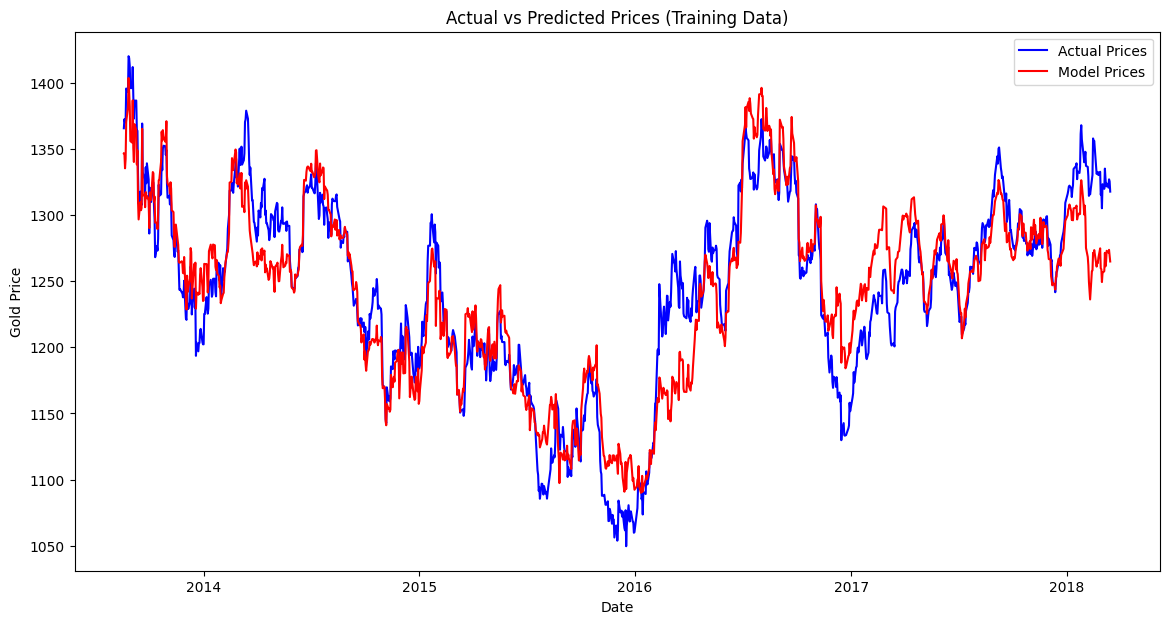

Training RMSE: 29.123743822180646


In [28]:
y_gold_train_pred = gold_model.predict(sm.add_constant(X_gold_train))

# Calculate the RMSE for the training predictions
gold_train_rmse = rmse(y_gold_train, y_gold_train_pred)

# Plotting the actual vs model prices for the training set
plt.figure(figsize=(14, 7))
plt.plot(y_gold_train.index, y_gold_train, label='Actual Prices', color='blue')
plt.plot(y_gold_train.index, y_gold_train_pred, label='Model Prices', color='red')

# Adding titles and labels
plt.title(f'Actual vs Predicted Prices (Training Data)')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.legend()
plt.show()
print(f'Training RMSE: {gold_train_rmse}')

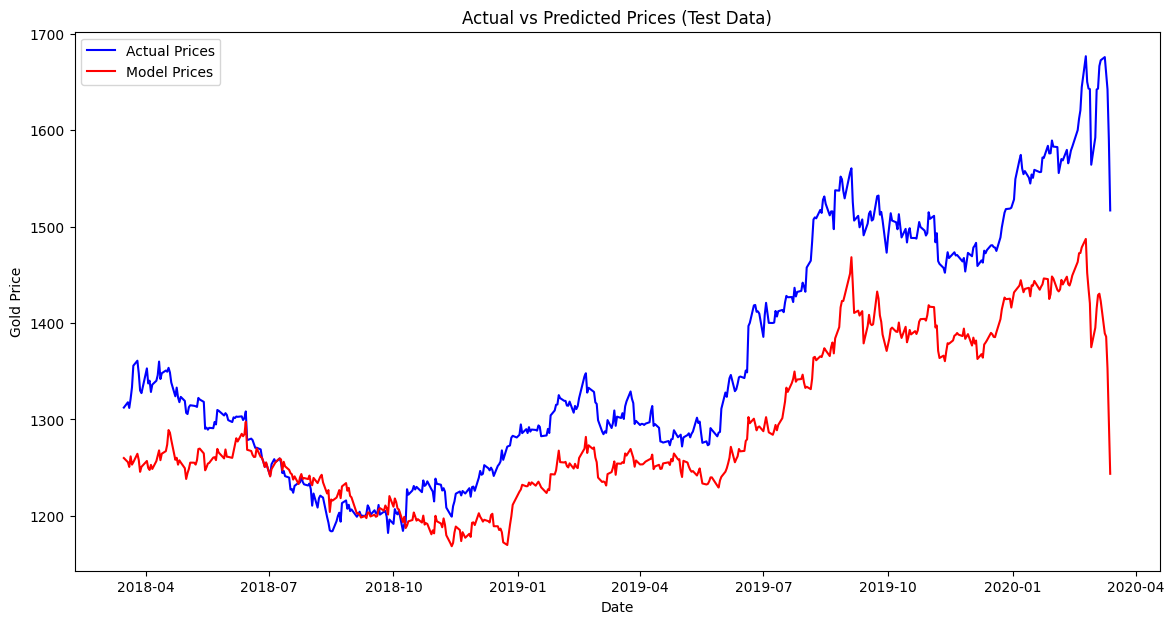

Test RMSE: 86.2750931622982


In [29]:
# Plotting the actual vs predicted prices

plt.figure(figsize=(14, 7))
plt.plot(y_gold_test.index, y_gold_test, label='Actual Prices', color='blue')
plt.plot(y_gold_test.index, y_gold_pred, label='Model Prices', color='red')

# Adding titles and labels
plt.title(f'Actual vs Predicted Prices (Test Data)')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.legend()
plt.show()
print(f'Test RMSE: {gold_test_rmse}')